# DDoS Attack Detection in Healthcare IoT Networks using UDP Dataset
# UL-ECE-UDP-DDoS-H-IoT2025 Analysis

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🏥 Healthcare IoT DDoS Detection System")
print("=" * 50)

🏥 Healthcare IoT DDoS Detection System


## 1. Data Loading and Initial Exploration

In [5]:
def load_and_explore_data(file_path):
    """Load the UDP dataset and perform initial exploration"""
    print("\n📊 Loading UDP DDoS Dataset...")

    # Load the dataset
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    print(df.head())

    print(f"\nDataset Info:")
    print(df.info())

    print(f"\nMissing values:")
    print(df.isnull().sum())

    print(f"\nTarget distribution:")
    print(df['outcome'].value_counts())

    return df

## 2. Data Preprocessing and Feature Engineering

In [6]:
def preprocess_data(df):
    """Preprocess the data for machine learning"""
    print("\n🔧 Preprocessing Data...")

    # Create a copy to avoid modifying original data
    data = df.copy()

    # Handle categorical variables if any (IP addresses are already encoded as numbers)
    categorical_columns = ['protocol_des', 'source_ip_des', 'destination_ip_des']

    # Encode categorical variables
    label_encoders = {}
    for col in categorical_columns:
        if col in data.columns:
            le = LabelEncoder()
            data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
            label_encoders[col] = le

    # Select features for modeling (excluding original categorical columns and identifiers)
    feature_columns = [
        'time_elapsed', 'node_id', 'protocol', 'source_ip', 'destination_ip',
        'payload_size', 'total_messages', 'total_messages_same_node',
        'frequency', 'mean_frequency', 'monitoring_frequency',
        'monitoring_total_messages', 'monitoring_total_messages_same_node'
    ]

    # Add encoded categorical features if they exist
    for col in categorical_columns:
        if col + '_encoded' in data.columns:
            feature_columns.append(col + '_encoded')

    # Extract features and target
    X = data[feature_columns]
    y = data['outcome']

    print(f"Features selected: {feature_columns}")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    return X, y, label_encoders

## 3. Feature Analysis and Visualization

In [7]:
def analyze_features(X, y):
    """Analyze and visualize feature distributions"""
    print("\n📈 Feature Analysis...")

    # Create subplots for feature distributions
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    numeric_features = X.select_dtypes(include=[np.number]).columns[:12]

    for i, feature in enumerate(numeric_features):
        if i < len(axes):
            # Box plot for each feature by outcome
            sns.boxplot(data=pd.concat([X, y], axis=1), x='outcome', y=feature, ax=axes[i])
            axes[i].set_title(f'{feature} by Outcome')
            axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(14, 10))
    correlation_matrix = X.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

## 4. Model Implementation and Training

In [8]:
def train_models(X_train, X_test, y_train, y_test):
    """Train multiple models and compare performance"""
    print("\n🤖 Training Multiple Models...")

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=42
        ),
        'Support Vector Machine': SVC(
            kernel='rbf',
            C=1.0,
            probability=True,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42,
            max_iter=1000
        ),
        'Decision Tree': DecisionTreeClassifier(
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2
        )
    }

    # Train and evaluate models
    results = {}
    trained_models = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        results[name] = {
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }

        print(f"{name} - Accuracy: {accuracy:.4f}, CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

    return trained_models, results

## 5. Model Evaluation and Comparison

In [9]:
def evaluate_models(models, results, X_test, y_test):
    """Detailed evaluation and comparison of models"""
    print("\n📊 Detailed Model Evaluation...")

    # Performance comparison
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Test Accuracy': [results[model]['accuracy'] for model in results.keys()],
        'CV Mean': [results[model]['cv_mean'] for model in results.keys()],
        'CV Std': [results[model]['cv_std'] for model in results.keys()]
    })

    print("\nModel Performance Comparison:")
    print(performance_df.round(4))

    # Plot performance comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    ax1.bar(performance_df['Model'], performance_df['Test Accuracy'])
    ax1.set_title('Test Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)

    # Cross-validation comparison with error bars
    ax2.bar(performance_df['Model'], performance_df['CV Mean'],
            yerr=performance_df['CV Std'], capsize=5)
    ax2.set_title('Cross-Validation Score Comparison')
    ax2.set_ylabel('CV Score')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Detailed classification reports for top 3 models
    top_models = performance_df.nlargest(3, 'Test Accuracy')['Model'].values

    print("\n📋 Detailed Classification Reports (Top 3 Models):")
    for model_name in top_models:
        print(f"\n{model_name}:")
        print("-" * 40)
        print(classification_report(y_test, results[model_name]['predictions']))

    # Confusion matrices for top 3 models
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, model_name in enumerate(top_models):
        cm = confusion_matrix(y_test, results[model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name}\nConfusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

## 6. Feature Importance Analysis

In [10]:
def analyze_feature_importance(models, feature_names):
    """Analyze feature importance for tree-based models"""
    print("\n🔍 Feature Importance Analysis...")

    # Models with feature importance
    importance_models = ['Random Forest', 'Gradient Boosting', 'Decision Tree']

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for i, model_name in enumerate(importance_models):
        if model_name in models:
            model = models[model_name]
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                indices = np.argsort(importances)[::-1]

                # Plot feature importance
                axes[i].bar(range(len(importances)), importances[indices])
                axes[i].set_title(f'{model_name}\nFeature Importance')
                axes[i].set_xlabel('Features')
                axes[i].set_ylabel('Importance')
                axes[i].set_xticks(range(len(importances)))
                axes[i].set_xticklabels([feature_names[j] for j in indices], rotation=45, ha='right')

                # Print top 10 features
                print(f"\nTop 10 features for {model_name}:")
                for j in range(min(10, len(indices))):
                    idx = indices[j]
                    print(f"{j+1:2d}. {feature_names[idx]:30s} {importances[idx]:.4f}")

    plt.tight_layout()
    plt.show()

## 7. ROC Curve Analysis

In [11]:
def plot_roc_curves(results, y_test):
    """Plot ROC curves for all models"""
    print("\n📈 ROC Curve Analysis...")

    plt.figure(figsize=(12, 8))

    for model_name, result in results.items():
        if result['probabilities'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
            auc_score = roc_auc_score(y_test, result['probabilities'])
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - DDoS Detection Models')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 8. Hyperparameter Tuning for Best Model

In [12]:
def tune_best_model(X_train, y_train, X_test, y_test):
    """Hyperparameter tuning for Random Forest (typically the best performer)"""
    print("\n⚙️ Hyperparameter Tuning for Random Forest...")

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    # Grid search
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Best model evaluation
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    print(f"Test accuracy with best model: {accuracy:.4f}")

    return best_model

## 9. Main Execution Pipeline

In [17]:
# Load data
file_path = '/content/UL-ECE-UDP-DDoS-H-IoT2025.csv'

try:
    df = load_and_explore_data(file_path)
except FileNotFoundError:
    print("⚠️ Dataset file not found. Please upload your CSV file and update the file_path variable.")
else:
    # Preprocess data
    X, y, encoders = preprocess_data(df)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nData split completed:")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")



📊 Loading UDP DDoS Dataset...
Dataset shape: (99887, 18)
Columns: ['timestamp', 'time_elapsed', 'node_id', 'protocol', 'protocol_des', 'source_ip', 'source_ip_des', 'destination_ip', 'destination_ip_des', 'payload_size', 'total_messages', 'total_messages_same_node', 'frequency', 'mean_frequency', 'monitoring_frequency', 'monitoring_total_messages', 'monitoring_total_messages_same_node', 'outcome']

First few rows:
   timestamp  time_elapsed  node_id  protocol     protocol_des  source_ip  \
0   0.016516           0.0       19         0  ns3::Ipv4Header          7   
1   0.016516           0.0       20         0  ns3::Ipv4Header          8   
2   0.016516           0.0       21         0  ns3::Ipv4Header          9   
3   0.016516           0.0       22         0  ns3::Ipv4Header         10   
4   0.016516           0.0       23         0  ns3::Ipv4Header         11   

  source_ip_des  destination_ip destination_ip_des  payload_size  \
0      7.0.0.17               0            7.0.0.2


📈 Feature Analysis...


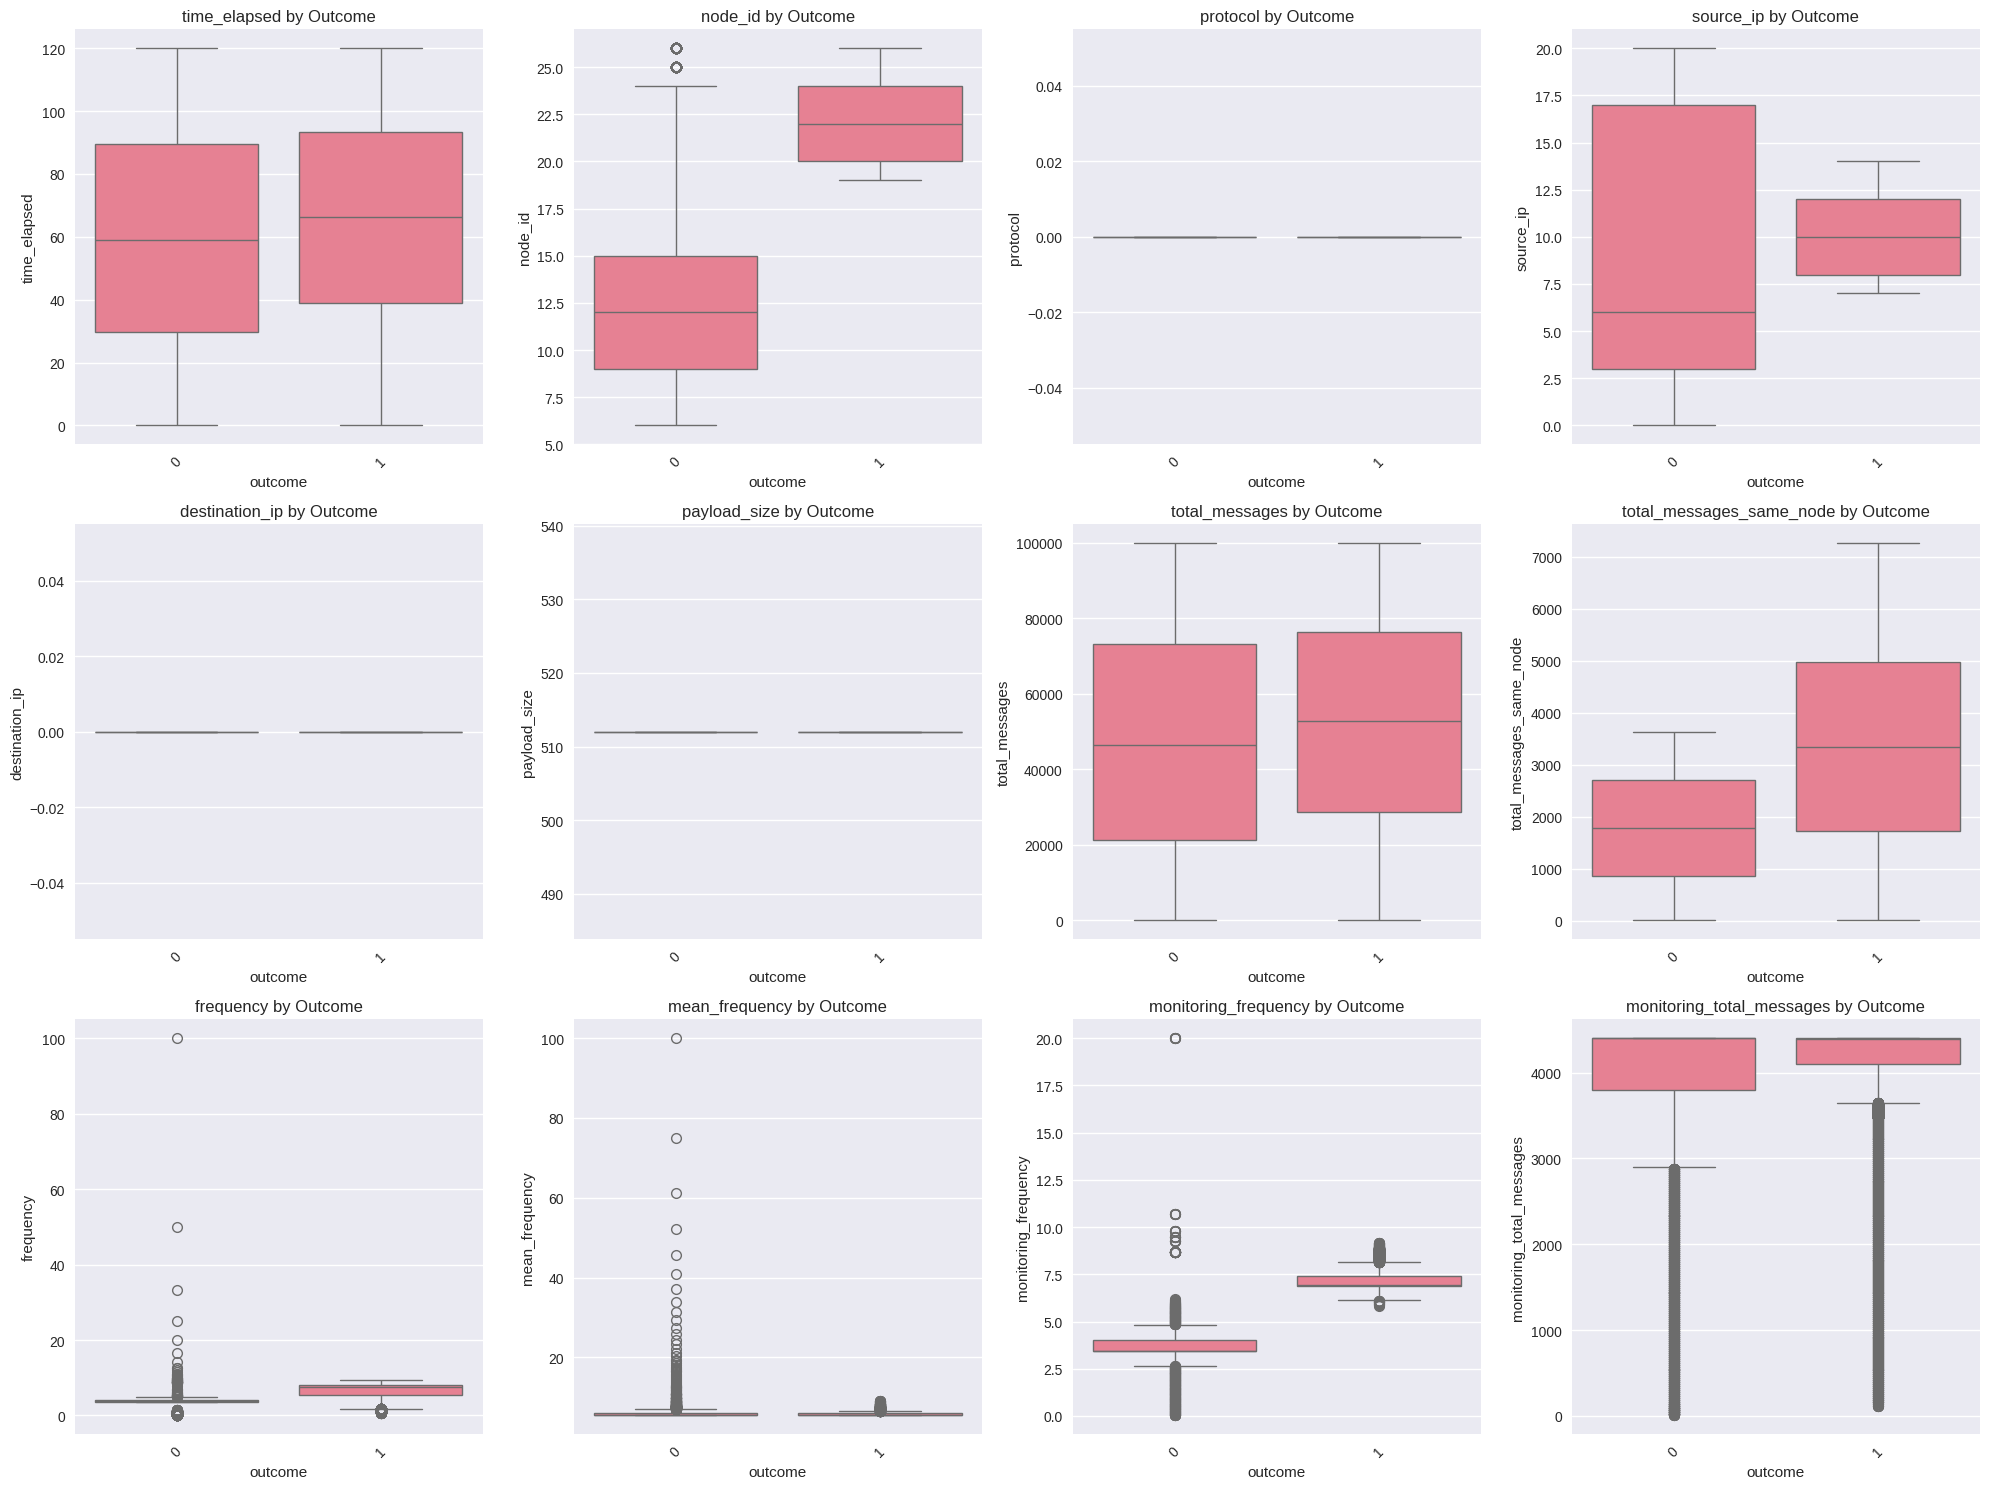

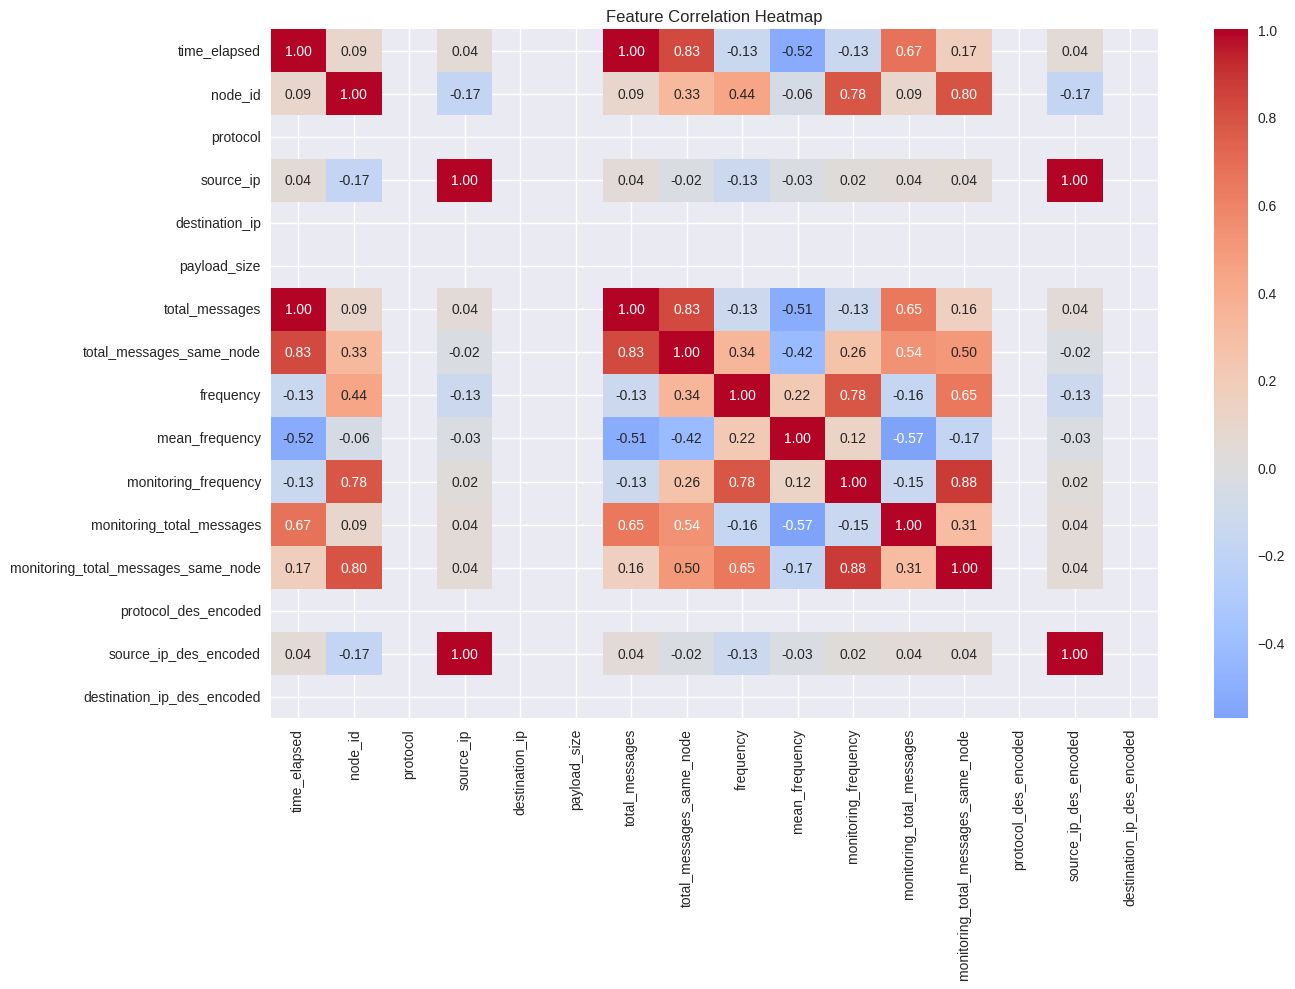

In [18]:
# Feature analysis
analyze_features(X, y)

In [19]:
# Train models
trained_models, results = train_models(X_train_scaled, X_test_scaled, y_train, y_test)


🤖 Training Multiple Models...

Training Random Forest...
Random Forest - Accuracy: 1.0000, CV Score: 0.9999 (+/- 0.0001)

Training Gradient Boosting...
Gradient Boosting - Accuracy: 1.0000, CV Score: 1.0000 (+/- 0.0001)

Training Support Vector Machine...
Support Vector Machine - Accuracy: 0.9998, CV Score: 0.9998 (+/- 0.0002)

Training Logistic Regression...
Logistic Regression - Accuracy: 0.9999, CV Score: 0.9999 (+/- 0.0001)

Training Decision Tree...
Decision Tree - Accuracy: 1.0000, CV Score: 1.0000 (+/- 0.0001)



📊 Detailed Model Evaluation...

Model Performance Comparison:
                    Model  Test Accuracy  CV Mean  CV Std
0           Random Forest         1.0000   0.9999  0.0000
1       Gradient Boosting         1.0000   1.0000  0.0000
2  Support Vector Machine         0.9998   0.9998  0.0001
3     Logistic Regression         0.9999   0.9999  0.0000
4           Decision Tree         1.0000   1.0000  0.0000


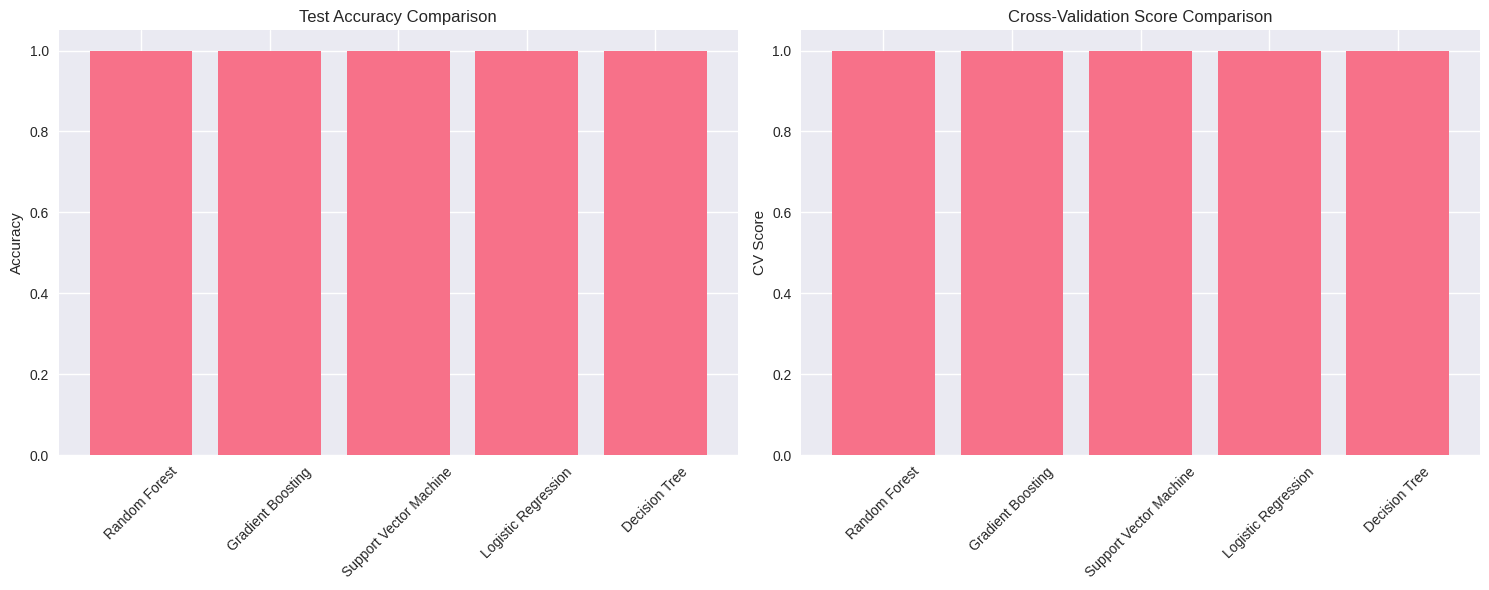


📋 Detailed Classification Reports (Top 3 Models):

Random Forest:
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9599
           1       1.00      1.00      1.00     10379

    accuracy                           1.00     19978
   macro avg       1.00      1.00      1.00     19978
weighted avg       1.00      1.00      1.00     19978


Gradient Boosting:
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9599
           1       1.00      1.00      1.00     10379

    accuracy                           1.00     19978
   macro avg       1.00      1.00      1.00     19978
weighted avg       1.00      1.00      1.00     19978


Decision Tree:
----------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9599
           

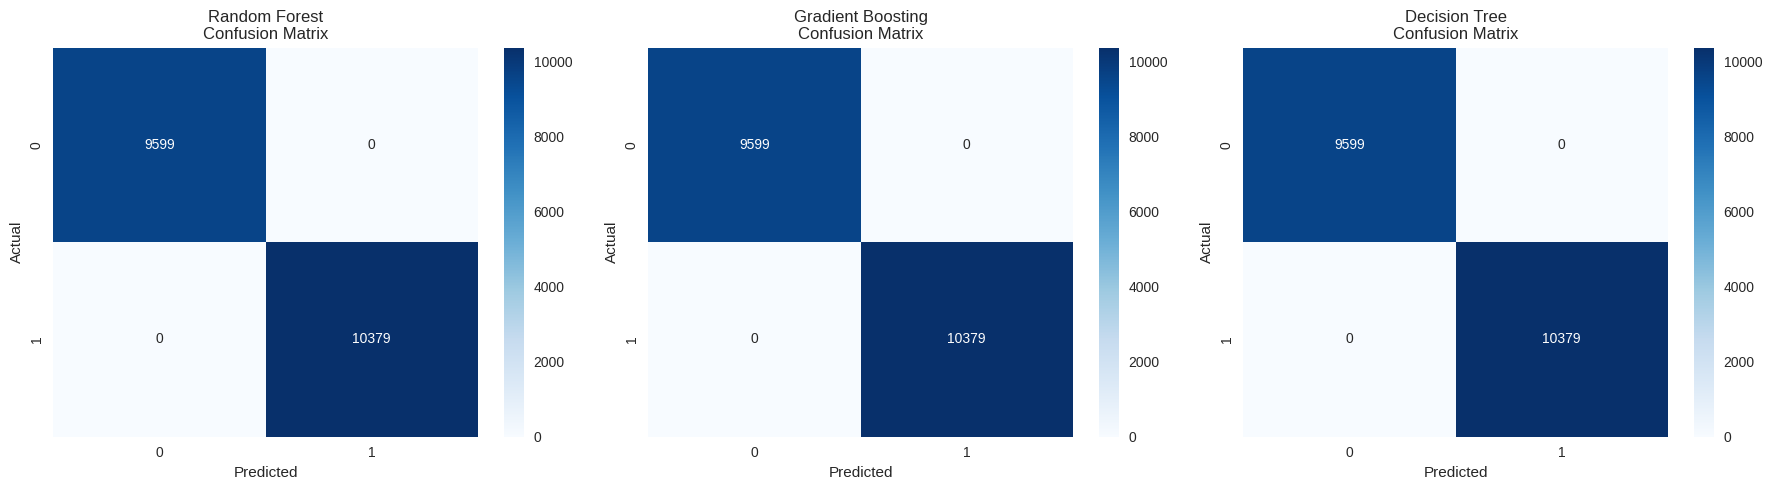

In [20]:
# Evaluate models
evaluate_models(trained_models, results, X_test_scaled, y_test)


🔍 Feature Importance Analysis...

Top 10 features for Random Forest:
 1. monitoring_frequency           0.3926
 2. monitoring_total_messages_same_node 0.2041
 3. node_id                        0.1912
 4. frequency                      0.0997
 5. source_ip                      0.0554
 6. source_ip_des_encoded          0.0293
 7. total_messages_same_node       0.0169
 8. monitoring_total_messages      0.0062
 9. time_elapsed                   0.0028
10. total_messages                 0.0012

Top 10 features for Gradient Boosting:
 1. monitoring_frequency           0.9972
 2. monitoring_total_messages      0.0011
 3. monitoring_total_messages_same_node 0.0007
 4. total_messages_same_node       0.0006
 5. total_messages                 0.0003
 6. time_elapsed                   0.0000
 7. frequency                      0.0000
 8. source_ip                      0.0000
 9. mean_frequency                 0.0000
10. source_ip_des_encoded          0.0000

Top 10 features for Decision Tree:
 1. 

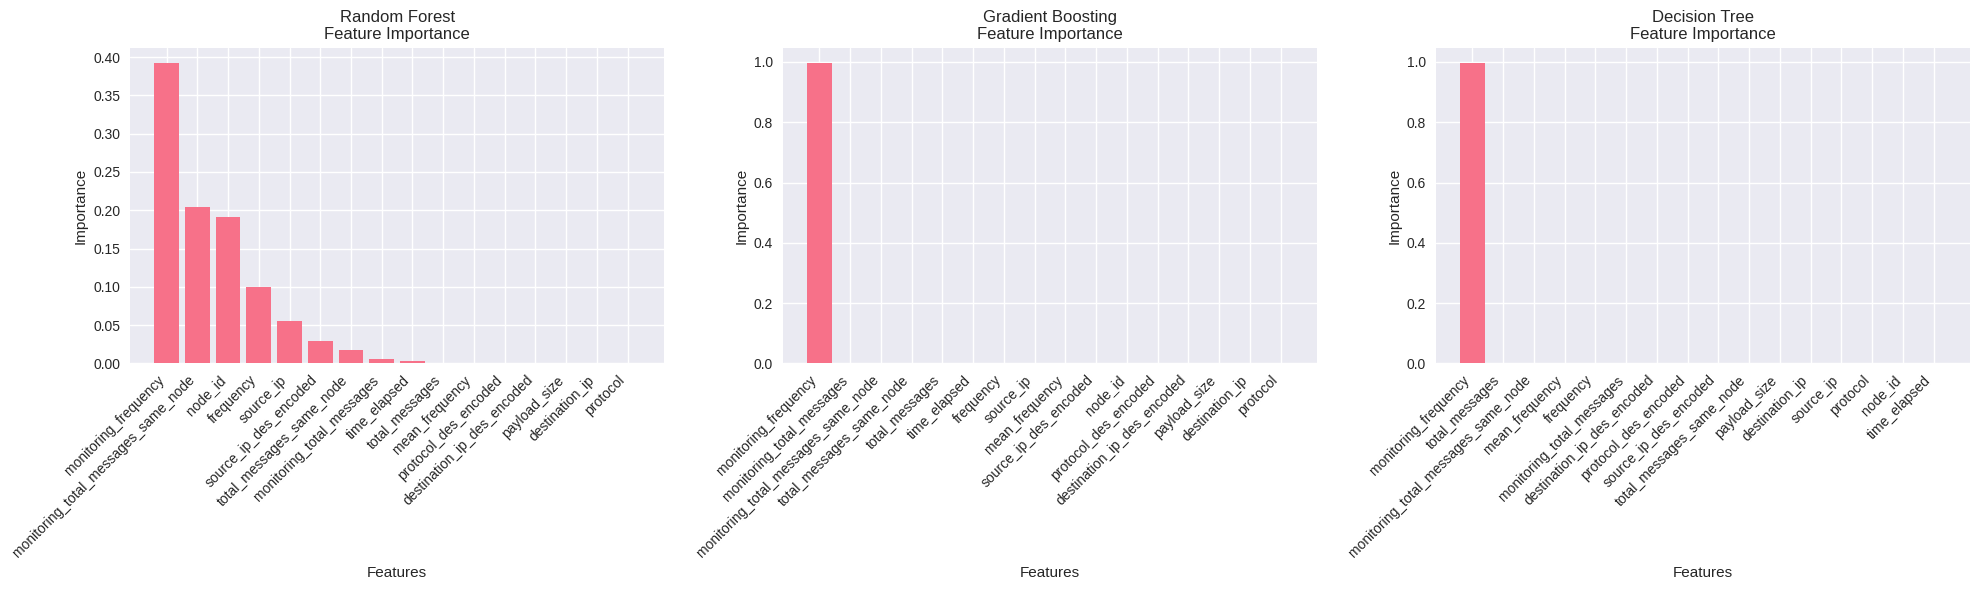

In [21]:
# Feature importance analysis
analyze_feature_importance(trained_models, X.columns.tolist())


📈 ROC Curve Analysis...


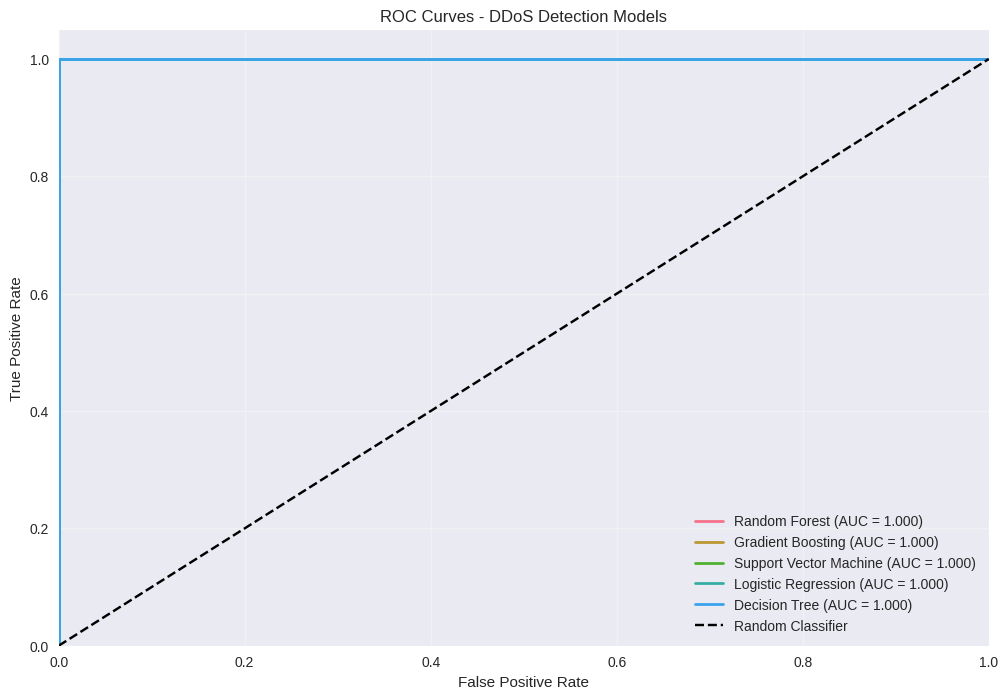

In [22]:
# ROC curves
plot_roc_curves(results, y_test)